This script generates Fig. 6F on the correlation between transcription and trans AB density changes by Mecp2 deletion

In [25]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import sys

print(f'PID number is {os.getpid()}')
    
figure_folder = r'C:\Users\cosmosyw\Documents\Research\Mecp2_v2\analysis\figures\scRNA\figures'

mpl.rc('figure', dpi=300)
mpl.rc('figure', titlesize=10.) 
mpl.rc('figure.constrained_layout', use=True)

mpl.rc('axes', labelsize=8.)
mpl.rc('axes', titlesize=9.)
mpl.rc('axes', linewidth=0.5)

mpl.rc('font', family='Arial')

mpl.rc('savefig', dpi=300)
mpl.rc('savefig', format='pdf')

mpl.rc('xtick', labelsize=7.)
mpl.rc('xtick.major', size=3)
mpl.rc('xtick.major', width=0.5)

mpl.rc('ytick', labelsize=7.)
mpl.rc('ytick.major', size=3)
mpl.rc('ytick.major', width=0.5)

mpl.rcParams['pdf.fonttype'] = 42

PID number is 12276


# Load DEG

In [26]:
df_deg = pd.read_csv('Greenberg_scRNA_male_Mecp2_DEG_majortype.csv', index_col=0)

### clean up
df_deg = df_deg[df_deg['names']!='Mecp2'].copy() # remove Mecp2

df_deg.rename({'names':'gene', 'cell_type':'majortype'}, axis=1, inplace=True)

print(len(df_deg))

df_deg.head()

105129


,gene,scores,logfoldchanges,pvals,pvals_adj,majortype
1,Ctxn1,-13.814858,-0.598430,2.073612e-43,2.383617e-40,Gluta
2,Eef1a2,-13.691930,-0.457822,1.134548e-42,1.247460e-39,Gluta
3,Dynll1,-12.686783,-0.553000,7.000236e-37,5.532155e-34,Gluta
4,Junb,-12.331744,-1.387881,6.110939e-35,4.545280e-32,Gluta
5,Sept5,-12.321713,-0.458796,6.920805e-35,5.000578e-32,Gluta


In [27]:
### add Mecp2 effect

def get_Mecp2_effect(pval, log2fc, pval_thresh = 0.01):
    if pval>pval_thresh:
        return 'NE'
    elif log2fc>0:
        return 'Up-regulated'
    elif log2fc<0:
        return 'Down-regulated'
    else:
        return 'NE'

df_deg['Mecp2_effect'] = df_deg.apply(lambda x: get_Mecp2_effect(x['pvals_adj'], x['logfoldchanges']), axis=1)

# Load transAB change

In [28]:
# the trans AB density ratio changes by major type is calculated similar as the script in Step 0 in this folder
# the only difference is that it utilizes all cells from a majortype, for example excitatory neurons (Gluta)
df_transAB = pd.read_csv(r"C:\Users\cosmosyw\Documents\Research\Mecp2_v2\analysis\figures\scRNA\resources\gene_transAB_by_majortype.csv", index_col=0)
df_transAB = df_transAB[df_transAB['transAB_change']!=-100].copy()
df_transAB.head()

,gene,chr,start,end,position,transAB_change,majortype
0,0610006L08Rik,chr7,74818817,74853813,74836315.0,-0.085658,Gluta
1,0610007P14Rik,chr12,85815447,85824550,85819998.5,-0.058197,Gluta
2,0610009B22Rik,chr11,51685385,51688874,51687129.5,-0.012675,Gluta
3,0610009E02Rik,chr2,26445695,26459390,26452542.5,-0.063708,Gluta
4,0610009L18Rik,chr11,120348677,120351190,120349933.5,-0.079699,Gluta


In [29]:
df_deg_with_transABchange = df_deg.merge(df_transAB.loc[:,['gene','majortype','transAB_change']], left_on=['gene','majortype'],
                             right_on=['gene', 'majortype'])

print(len(df_deg_with_transABchange))

df_deg_with_transABchange.head()

59349


,gene,scores,logfoldchanges,pvals,pvals_adj,majortype,Mecp2_effect,transAB_change
0,Ctxn1,-13.814858,-0.598430,2.073612e-43,2.383617e-40,Gluta,Down-regulated,-0.055666
1,Eef1a2,-13.691930,-0.457822,1.134548e-42,1.247460e-39,Gluta,Down-regulated,-0.092771
2,Dynll1,-12.686783,-0.553000,7.000236e-37,5.532155e-34,Gluta,Down-regulated,-0.103303
3,Junb,-12.331744,-1.387881,6.110939e-35,4.545280e-32,Gluta,Down-regulated,-0.041345
4,Sept5,-12.321713,-0.458796,6.920805e-35,5.000578e-32,Gluta,Down-regulated,-0.025340


# Plot DEG radial position by majortypes

In [71]:
### define function and interval for line plot
df_plot = df_deg_with_transABchange[df_deg_with_transABchange.majortype=='Gluta'].copy()

import math

def get_interval(transab):
    linspace = np.linspace(-0.1,0.1,11)
    interval = np.argmax(linspace>=transab)
    # group all loci with trans AB density change >0.1 into one group
    # similarly, all loci with trans AB density change <-0.1 will be grouped together in this function.
    if transab>0.1:
        return 0.12
    else:
        return linspace[interval]

df_plot['transAB_change_interval'] = df_plot['transAB_change'].apply(lambda x: get_interval(x))

In [77]:
linspace = np.linspace(-0.1,0.1,11)
linspace

array([-0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
        0.08,  0.1 ])

In [72]:
df_plot['transAB_change_interval'] = df_plot['transAB_change_interval'] - 0.01

In [74]:
np.unique(df_plot['transAB_change_interval'].values)

array([-0.11, -0.09, -0.07, -0.05, -0.03, -0.01,  0.01,  0.03,  0.05,
        0.07,  0.09,  0.11])

meta NOT subset; don't know how to subset; dropped


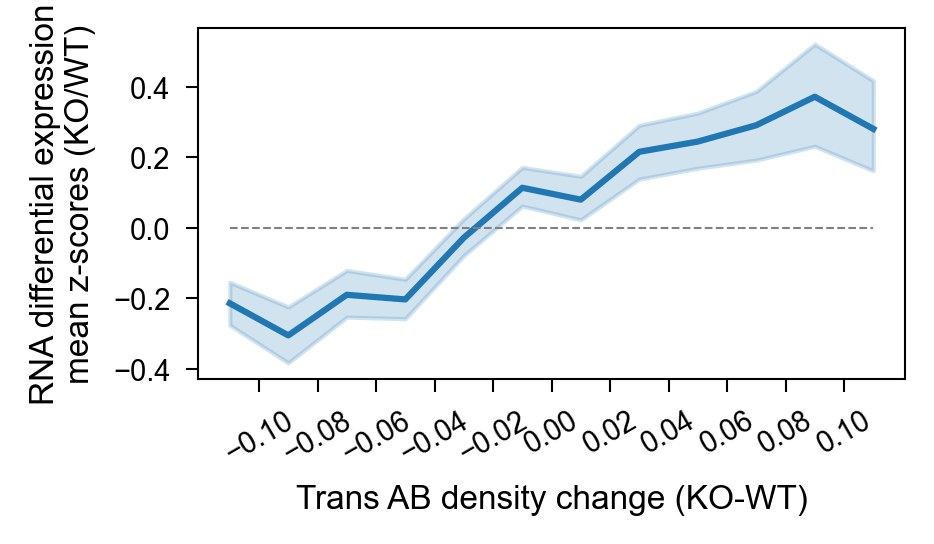

In [82]:
fig = plt.figure(figsize=(3.0,1.7), dpi=300)

ax = fig.add_subplot(111)

sns.lineplot(data=df_plot, x='transAB_change_interval', y='scores', ax=ax)

ax.plot([-0.11,0.11], [0,0], linewidth=0.5, color='gray', linestyle='--')

ax.set_ylabel('RNA differential expression\nmean z-scores (KO/WT)')
ax.set_xlabel('Trans AB density change (KO-WT)')

ax.set_xticks([-0.1,-0.08,-0.06,-0.04,-0.02,0,0.02,0.04,0.06,0.08,0.1])
ax.tick_params(axis='x', rotation=30)

figure_name = 'scRNA_Mecp2_score_by_transAB_ratio.pdf'
plt.savefig(figure_name)

plt.show()